<a href="https://colab.research.google.com/github/Shekhawat34/LSTM_XG-Boost_model_for_Stock_Price_Prediction/blob/main/CNN_LSTM_and_XGBoost_model_for_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PROJECT:- CNN-LSTM and XGBoost Model For Stock Prediction

In [ ]:
import numpy as np
import pandas as pd
from sklearn import metrics
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt

# define Augmented Dickey-Fuller (ADF) testm , auto correlation and partial auto correlation

In [ ]:
def adf_test(temp):
  t=adfuller(temp)
  output=pd.DataFrame(index=['Test Statistics Value','p-value','Lags Used','Number of Observations Used','Critical Value(1%)','Critical Value(5%)','Critical Value(10%)'],columns=['value'])
  output['value']['Test Statistic Value']=t[0]
  output['value']['p-value']=t[1]
  output['value']['Lags Used']=t[2]
  output['value']['Number of Observations Used']=t[3]
  output['value']['Critical Value(1%)']=t[4]['1%']
  output['value']['Critical Value(5%)']=t[4]['5%']
  output['value']['Critical Value(10%)']=t[4]['10%']
  print(output)


def acf_pacf_plot(seq,acf_lags=20,pacf_lags=20):
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(seq, lags=acf_lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(seq, lags=pacf_lags, ax=ax2)
    plt.show()

def order_select_ic(training_data_diff):
    (p, q) = sm.tsa.arma_order_select_ic(training_data_diff, max_ar=6, max_ma=4, ic='bic')['bic_min_order']  # AIC
    print(p, q)


In [ ]:
def order_select_search(training_set):
    df2 = training_set['close'].diff(1).dropna()

    pmax = 5
    qmax = 5
    bic_matrix = []
    print('^', pmax, '^^', qmax)
    for p in range(pmax + 1):
        temp3 = []
        for q in range(qmax+1):
            try:

                temp3.append(sm.tsa.ARIMA(training_set['close'], order=(p, 1, q)).fit().bic)
            except:
                temp3.append(None)
        bic_matrix.append(temp3)
    bic_matrix = pd.DataFrame(bic_matrix)

    p, q = bic_matrix.stack().astype('float64').idxmin()
    print('p and q: %s,%s' % (p, q))


## Prepare data for training and testing

In [ ]:
def create_dataset(dataset, look_back=20):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),:]
        dataX.append(a)
        dataY.append(dataset[i + look_back,:])
    TrainX = np.array(dataX)
    Train_Y = np.array(dataY)

    return TrainX, Train_Y

In [ ]:
def evaluation_metric(y_test,y_hat):
    MSE = metrics.mean_squared_error(y_test, y_hat)
    RMSE = MSE**0.5
    MAE = metrics.mean_absolute_error(y_test,y_hat)
    R2 = metrics.r2_score(y_test,y_hat)
    print('MSE: %.5f' % MSE)
    print('RMSE: %.5f' % RMSE)
    print('MAE: %.5f' % MAE)
    print('R2: %.5f' % R2)

def GetMAPE(y_hat, y_test):
    sum = np.mean(np.abs((y_hat - y_test) / y_test)) * 100
    return sum

In [ ]:
def GetMAPE_Order(y_hat,y_test):
    zero_index = np.where(y_test == 0)
    y_hat = np.delete(y_hat, zero_index[0])
    y_test = np.delete(y_test, zero_index[0])
    sum = np.mean(np.abs((y_hat - y_test) / y_test)) * 100
    return sum

## Normalize the data

In [ ]:
def NormalizeMult(data):
    data = np.array(data)
    normalize = np.arange(2*data.shape[1], dtype='float64')

    normalize = normalize.reshape(data.shape[1],2)
    print(normalize.shape)
    for i in range(0, data.shape[1]):
        list = data[:, i]
        listlow, listhigh = np.percentile(list, [0, 100])
        # print(i)
        normalize[i, 0] = listlow
        normalize[i, 1] = listhigh
        delta = listhigh - listlow
        if delta != 0:
            for j in range(0, data.shape[0]):
                data[j, i] = (data[j, i] - listlow)/delta

    return data, normalize

In [ ]:
def FNormalizeMult(data, normalize):
    #inverse NormalizeMult
    data = np.array(data)
    listlow = normalize[0]
    listhigh = normalize[1]
    delta = listhigh - listlow
    if delta != 0:
        for i in range(len(data)):
            data[i, 0] = data[i, 0] * delta + listlow
    return data

def NormalizeMultUseData(data,normalize):
    data = np.array(data)
    for i in range(0, data.shape[1]):
        listlow = normalize[i, 0]
        listhigh = normalize[i, 1]
        delta = listhigh - listlow
        if delta != 0:
            for j in range(0,data.shape[0]):
                data[j,i]  =  (data[j,i] - listlow)/delta
    return  data

In [ ]:
def data_split(sequence, n_timestamp):
    X = []
    y = []
    for i in range(len(sequence)):
        end_ix = i + n_timestamp

        if end_ix > len(sequence) - 1:
            break

        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
def prepare_data(series, n_test, n_in, n_out):
    values = series.values
    supervised_data = series_to_supervised(values, n_in, n_out)
    print('supervised_data', supervised_data)
    train, test = supervised_data.loc[:3499, :], supervised_data.loc[3500:, :]
    return train, test

## Load data and perform data manipulation

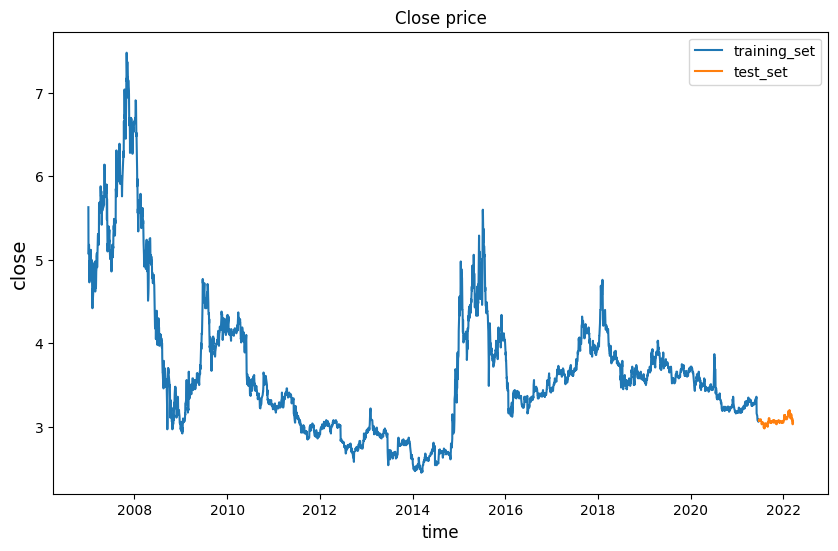

<ipython-input-81-f79fb2a2dc36>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['diff_1'] = training_set['close'].diff(1)


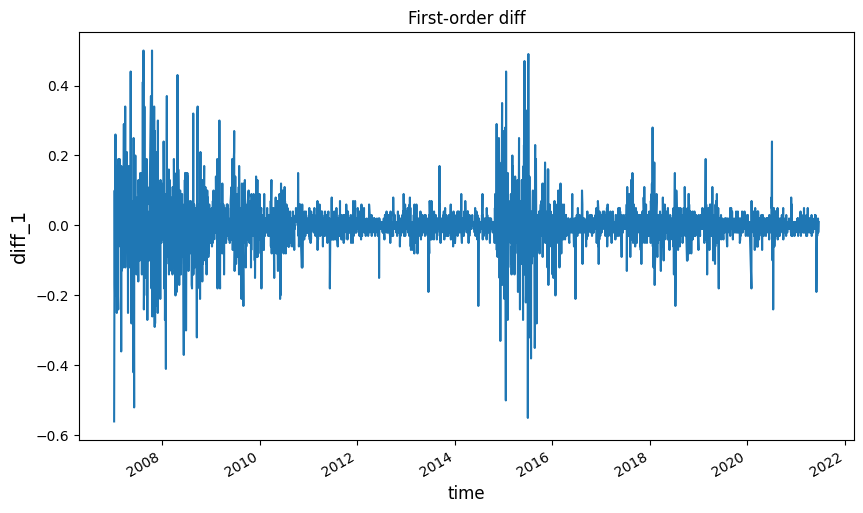

<ipython-input-81-f79fb2a2dc36>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['diff_2'] = training_set['diff_1'].diff(1)


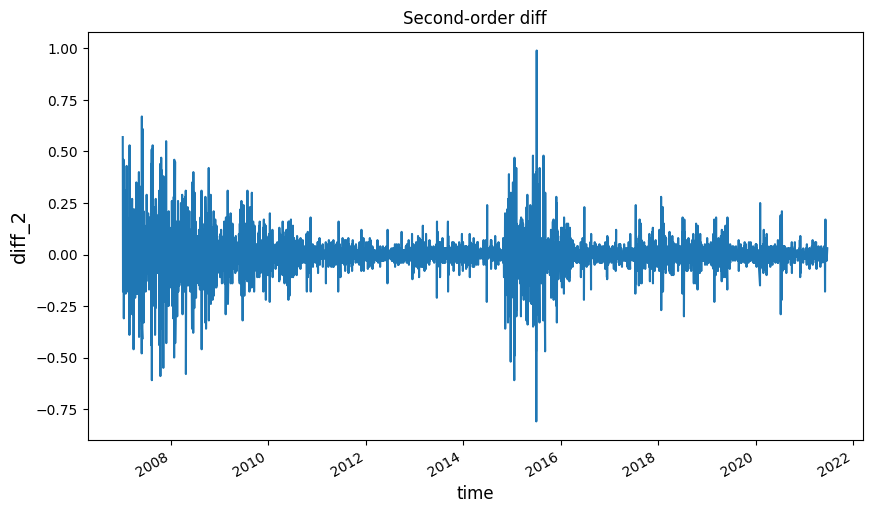

     lb_stat  lb_pvalue    bp_stat  bp_pvalue
1   3.458346   0.062933   3.455383   0.063046
2  23.695323   0.000007  23.669246   0.000007


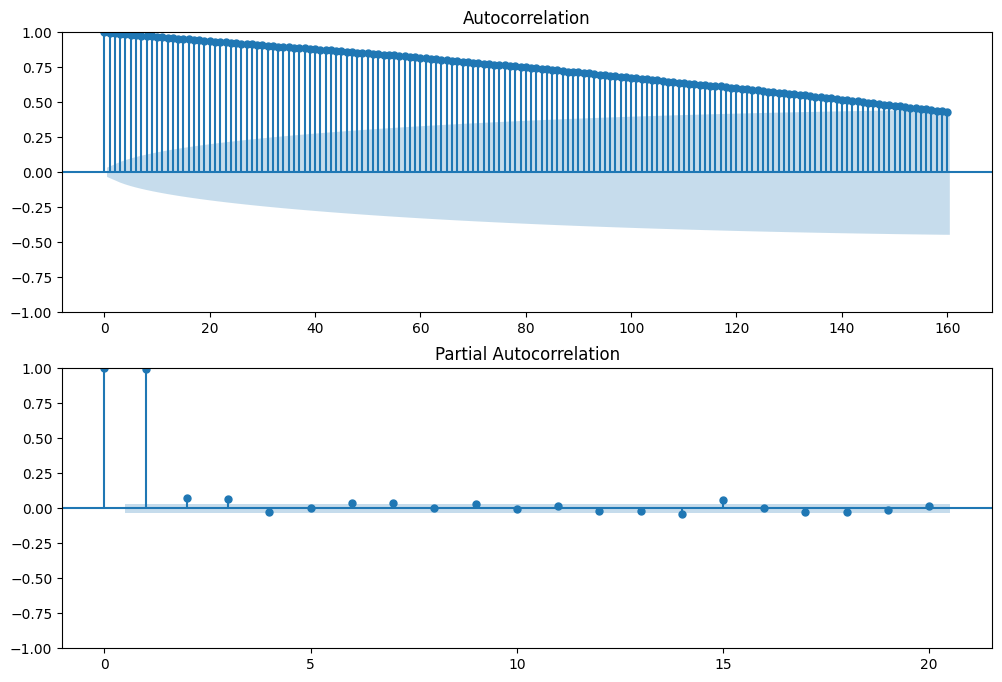

&             close
trade_date       
2007-01-05  -0.56
2007-01-08   0.01
2007-01-09   0.10
2007-01-10  -0.08
2007-01-11  -0.17
...           ...
2021-06-15  -0.01
2021-06-16   0.02
2021-06-17  -0.01
2021-06-18  -0.02
2021-06-21   0.01

[3500 rows x 1 columns]


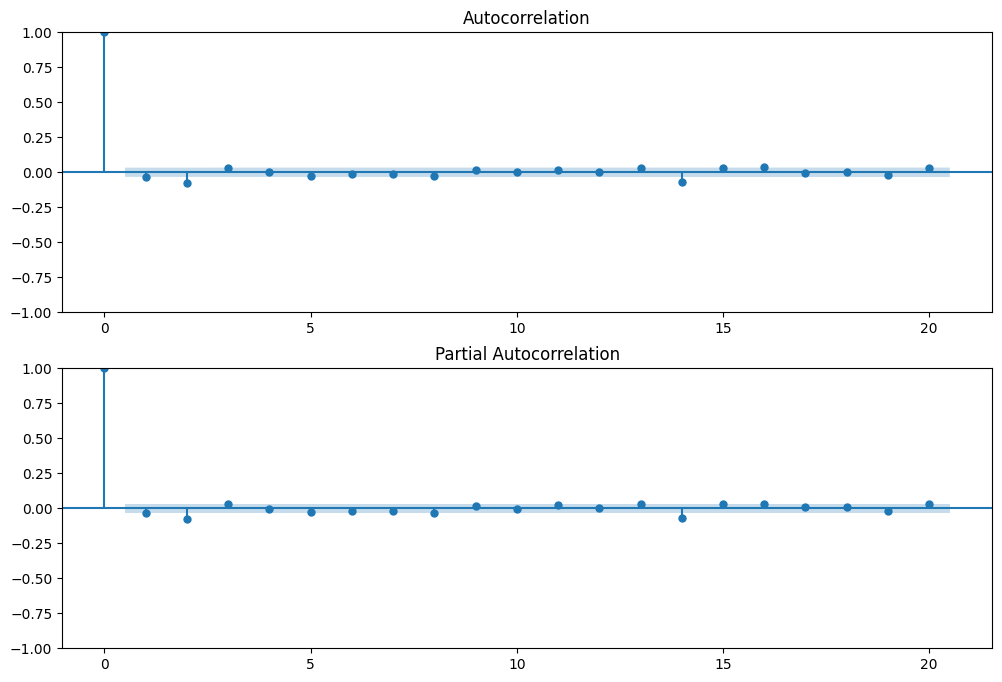

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


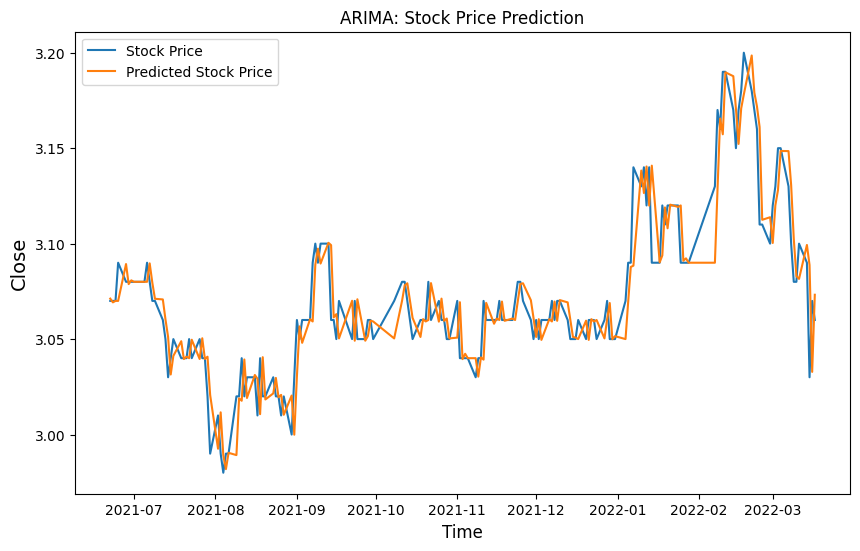

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


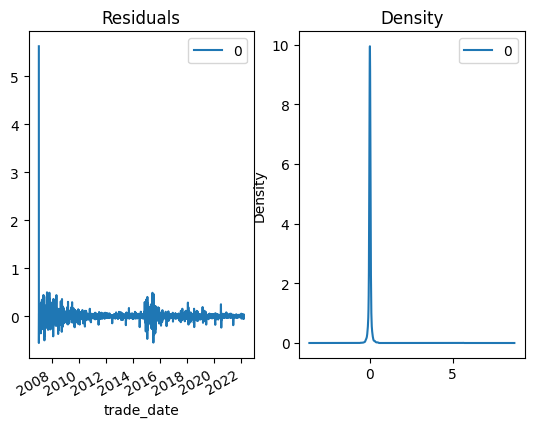

MSE: 0.00027
RMSE: 0.01650
MAE: 0.01197
R2: 0.84439


<ipython-input-71-b87e359bad9b>:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  output['value']['Test Statistic Value']=t[0]
<ipython-input-71-b87e359bad9b>:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You 

                                value
Test Statistics Value             NaN
p-value                      0.154726
Lags Used                          16
Number of Observations Used      3484
Critical Value(1%)          -3.432228
Critical Value(5%)           -2.86237
Critical Value(10%)         -2.567212


<ipython-input-71-b87e359bad9b>:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  output['value']['Test Statistic Value']=t[0]
<ipython-input-71-b87e359bad9b>:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You 

                                value
Test Statistics Value             NaN
p-value                           0.0
Lags Used                          15
Number of Observations Used      3484
Critical Value(1%)          -3.432228
Critical Value(5%)           -2.86237
Critical Value(10%)         -2.567212
# trade_date
2021-05-20    3.270340
2021-05-21    3.280430
2021-05-24    3.279230
2021-05-25    3.289660
2021-05-26    3.318209
2021-05-27    3.317690
2021-05-28    3.310340
2021-05-31    3.339749
2021-06-01    3.328031
2021-06-02    3.340430
2021-06-03    3.358550
2021-06-04    3.348801
2021-06-07    3.167235
2021-06-08    3.155308
2021-06-09    3.131880
2021-06-10    3.130770
2021-06-11    3.101021
2021-06-15    3.082990
2021-06-16    3.071880
2021-06-17    3.090089
2021-06-18    3.078801
2021-06-21    3.061450
dtype: float64


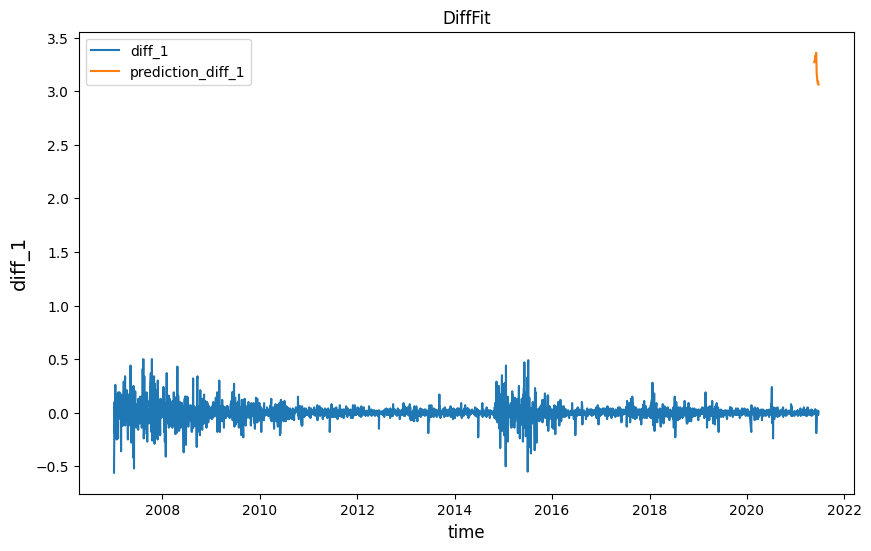

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn import metrics



data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/601988.SH.csv')
test_set2 = data.loc[3501:, :]
data.index = pd.to_datetime(data['trade_date'], format='%Y%m%d')
data = data.drop(['ts_code', 'trade_date'], axis=1)
data = pd.DataFrame(data, dtype=np.float64)

training_set = data.loc['2007-01-04':'2021-06-21', :]  # 3501
test_set = data.loc['2021-06-22':, :]  # 180

plt.figure(figsize=(10, 6))
plt.plot(training_set['close'], label='training_set')
plt.plot(test_set['close'], label='test_set')
plt.title('Close price')
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

temp = np.array(training_set['close'])

# First-order diff
training_set['diff_1'] = training_set['close'].diff(1)
plt.figure(figsize=(10, 6))
training_set['diff_1'].plot()
plt.title('First-order diff')
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('diff_1', fontsize=14, horizontalalignment='center')
plt.show()

# Second-order diff
training_set['diff_2'] = training_set['diff_1'].diff(1)
plt.figure(figsize=(10, 6))
training_set['diff_2'].plot()
plt.title('Second-order diff')
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('diff_2', fontsize=14, horizontalalignment='center')
plt.show()

temp1 = np.diff(training_set['close'], n=1)

# white noise test
training_data1 = training_set['close'].diff(1)
# training_data1_nona = training_data1.dropna()
temp2 = np.diff(training_set['close'], n=1)
# print(acorr_ljungbox(training_data1_nona, lags=2, boxpierce=True, return_df=True))
print(acorr_ljungbox(temp2, lags=2, boxpierce=True))
# p-value=1.53291527e-08, non-white noise time-seriess

acf_pacf_plot(training_set['close'],acf_lags=160)

price = list(temp2)
data2 = {
    'trade_date': training_set['diff_1'].index[1:],
    'close': price
}

df = pd.DataFrame(data2)
df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')

training_data_diff = df.set_index(['trade_date'], drop=True)
print('&', training_data_diff)

acf_pacf_plot(training_data_diff)


model = sm.tsa.ARIMA(endog=training_set['close'], order=(2, 1, 0)).fit()


history = [x for x in training_set['close']]

predictions = list()

for t in range(test_set.shape[0]):
    model1 = sm.tsa.ARIMA(history, order=(2, 1, 0))
    model_fit = model1.fit()
    yhat = model_fit.forecast()
    yhat = np.float32(yhat[0])
    predictions.append(yhat)
    obs = test_set2.iloc[t, 5]

    history.append(obs)


predictions1 = {
    'trade_date': test_set.index[:],
    'close': predictions
}
predictions1 = pd.DataFrame(predictions1)
predictions1 = predictions1.set_index(['trade_date'], drop=True)
predictions1.to_csv('./ARIMA.csv')
plt.figure(figsize=(10, 6))
plt.plot(test_set['close'], label='Stock Price')
plt.plot(predictions1, label='Predicted Stock Price')
plt.title('ARIMA: Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

model2 = sm.tsa.ARIMA(endog=data['close'], order=(2, 1, 0)).fit()
residuals = pd.DataFrame(model2.resid)
fig, ax = plt.subplots(1, 2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
residuals.to_csv('./ARIMA_residuals1.csv')
evaluation_metric(test_set['close'],predictions)
adf_test(temp)
adf_test(temp1)

predictions_ARIMA_diff = pd.Series(model.fittedvalues, copy=True)
predictions_ARIMA_diff = predictions_ARIMA_diff[3479:]
print('#', predictions_ARIMA_diff)
plt.figure(figsize=(10, 6))
plt.plot(training_data_diff, label="diff_1")
plt.plot(predictions_ARIMA_diff, label="prediction_diff_1")
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('diff_1', fontsize=14, horizontalalignment='center')
plt.title('DiffFit')
plt.legend()
plt.show()

## Define CNN-LSTM model

In [ ]:
from keras.layers import Input, Dense, LSTM, Conv1D, Dropout, Bidirectional, Multiply, Permute, Lambda, RepeatVector, Flatten
from keras.models import Model, Sequential
from keras import backend as K
import tensorflow as tf
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler  # For data normalization


In [ ]:
def lstm(model_type,X_train,yuan_X_train):
    if model_type == 1:
        # single-layer LSTM
        model = Sequential()
        model.add(LSTM(units=50, activation='relu',
                    input_shape=(X_train.shape[1], 1)))
        model.add(Dense(units=1))
        yuan_model = Sequential()
        yuan_model.add(LSTM(units=50, activation='relu',
                    input_shape=(yuan_X_train.shape[1], 5)))
        yuan_model.add(Dense(units=5))
    if model_type == 2:
        # multi-layer LSTM
        model = Sequential()
        model.add(LSTM(units=50, activation='relu', return_sequences=True,
                    input_shape=(X_train.shape[1], 1)))
        model.add(LSTM(units=50, activation='relu'))
        model.add(Dense(1))

        yuan_model = Sequential()
        yuan_model.add(LSTM(units=50, activation='relu', return_sequences=True,
                    input_shape=(yuan_X_train.shape[1], 5)))
        yuan_model.add(LSTM(units=50, activation='relu'))
        yuan_model.add(Dense(5))
    if model_type == 3:
        # BiLSTM
        model = Sequential()
        model.add(Bidirectional(LSTM(50, activation='relu'),
                                input_shape=(X_train.shape[1], 1)))
        model.add(Dense(1))

        yuan_model =Sequential()
        yuan_model.add(Bidirectional(LSTM(50, activation='relu'),
                                    input_shape=(yuan_X_train.shape[1], 5)))
        yuan_model.add(Dense(5))

    return model,yuan_model

## Define XG-Boosting

In [ ]:
def xgb_scheduler(data,y_hat):
    close = data.pop('close')
    data.insert(5, 'close', close)
    train, test = prepare_data(data, n_test=len(y_hat), n_in=6, n_out=1)
    testY, y_hat2 = walk_forward_validation(train, test)
    return testY, y_hat2

def xgboost_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)

    trainX, trainy = train[:, :-1], train[:, -1]

    # fit model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=20)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(np.asarray([testX]))
    return yhat[0]

def walk_forward_validation(train, test):
    predictions = list()
    train = train.values
    history = [x for x in train]
    # print('history', history)
    for i in range(len(test)):
        testX, testy = test.iloc[i, :-1], test.iloc[i, -1]
        # print('i', i, testX, testy)
        yhat = xgboost_forecast(history, testX)
        predictions.append(yhat)
        history.append(test.iloc[i, :])
        print(i+1, '>expected=%.6f, predicted=%.6f' % (testy, yhat))
    return test.iloc[:, -1],predictions

## Load the original data and the Arima Model trained Residual Data for prediction with XG-Boost.

supervised_data       var1(t-6)  var2(t-6)  var3(t-6)   var4(t-6)    var5(t-6)  var6(t-6)  \
6          5.69       5.97       5.37  7281333.33  4224852.614       5.63   
7          5.30       5.34       5.07  7867306.84  4050377.943       5.07   
8          4.87       5.14       4.83  5565756.49  2763751.983       5.08   
9          5.06       5.19       4.95  4334458.33  2198327.249       5.18   
10         5.25       5.29       5.05  3721171.25  1915221.182       5.10   
...         ...        ...        ...         ...          ...        ...   
3676       3.13       3.16       3.13  1374157.76   432082.360       3.15   
3677       3.15       3.16       3.14  1560240.83   490908.221       3.15   
3678       3.14       3.15       3.12  1360415.16   426283.660       3.13   
3679       3.12       3.14       3.10  1500377.44   467690.817       3.10   
3680       3.10       3.11       3.04  2660491.55   820162.507       3.08   

      var7(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  ...    va

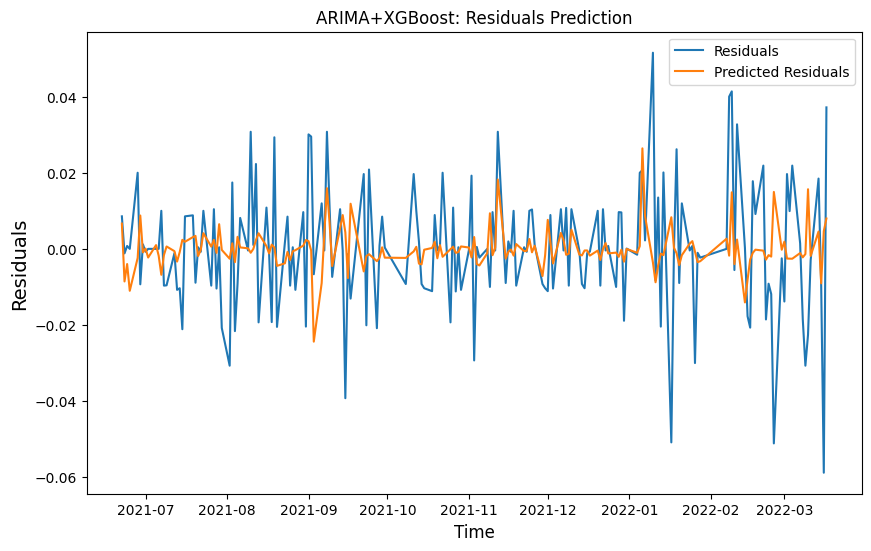

MSE: 0.00028
RMSE: 0.01687
MAE: 0.01274
R2: 0.83742


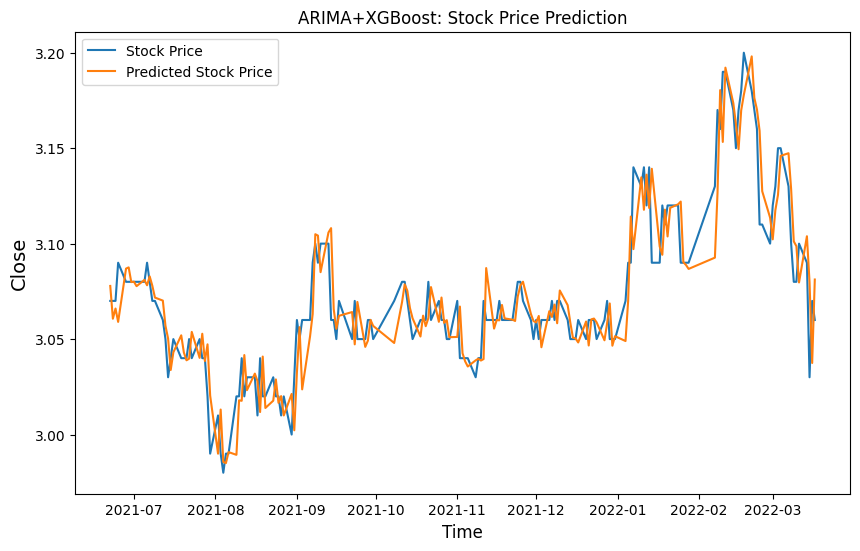

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/601988.SH.csv')
data.index = pd.to_datetime(data['trade_date'], format='%Y%m%d')
data = data.loc[:, ['open', 'high', 'low', 'close', 'vol', 'amount']]

close = data.pop('close')
data.insert(5, 'close', close)
data1 = data.iloc[3501:, 5]
residuals = pd.read_csv('/content/ARIMA_residuals1.csv')
residuals.index = pd.to_datetime(residuals['trade_date'])
residuals.pop('trade_date')
merge_data = pd.merge(data, residuals, on='trade_date')

time = pd.Series(data.index[3501:])

Lt = pd.read_csv('/content/ARIMA.csv')
Lt = Lt.drop('trade_date', axis=1)
Lt = np.array(Lt)
Lt = Lt.flatten().tolist()

train, test = prepare_data(merge_data, n_test=180, n_in=6, n_out=1)


y, yhat = walk_forward_validation(train, test)
y = y[:len(time)]
yhat = yhat[:len(time)]
plt.figure(figsize=(10, 6))
plt.plot(time, y, label='Residuals')
plt.plot(time, yhat, label='Predicted Residuals')
plt.title('ARIMA+XGBoost: Residuals Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Residuals', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

finalpredicted_stock_price = [i + j for i, j in zip(Lt, yhat)]
#print('final', finalpredicted_stock_price)
evaluation_metric(data1, finalpredicted_stock_price)
plt.figure(figsize=(10, 6))
plt.plot(time, data1, label='Stock Price') # data1 should be sliced to have the same length as time
plt.plot(time, finalpredicted_stock_price, label='Predicted Stock Price')
plt.title('ARIMA+XGBoost: Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

##  CNN-LSTM to improve the previous result

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_15 (Bidirectional)     │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,901 (81.64 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0265 - val_loss: 0.0248
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0052 - val_loss: 0.0247
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0051 - val_loss: 0.0246
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0051 - val_loss: 0.0245
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0050 - val_loss: 0.0245
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0050 - val_loss: 0.0244
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0050 - val_loss: 0.0243
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0050 - val_loss: 0.0242
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0050 - val_loss: 0.0242
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0049 - val_loss: 0.0241
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0049 - val_loss: 0.0240
Epoch 12/50
110/110 ━━━━━━━━━━━━━━━━

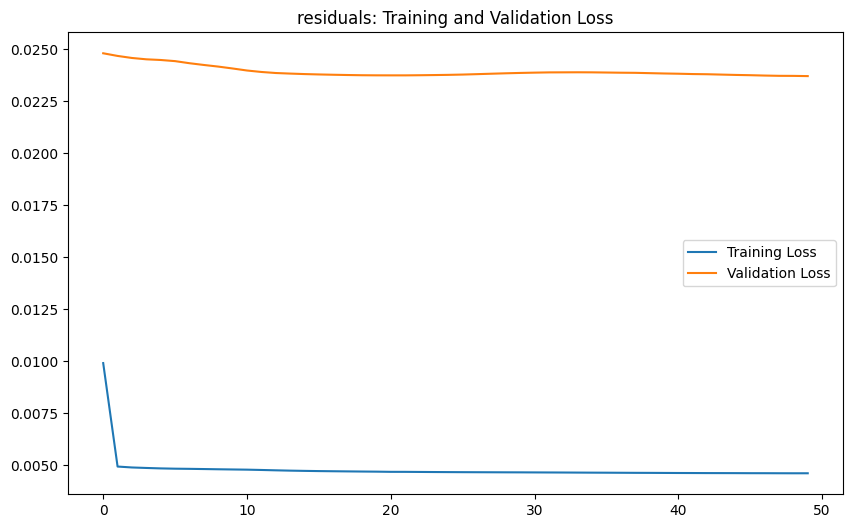

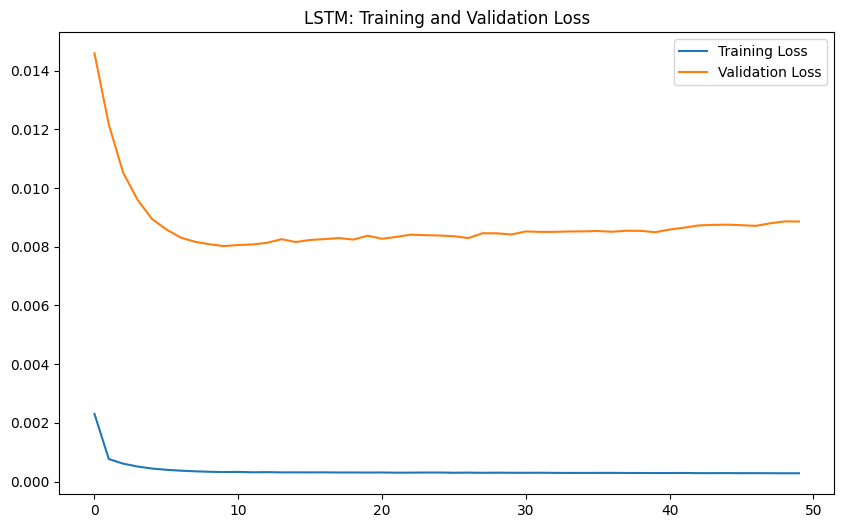

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


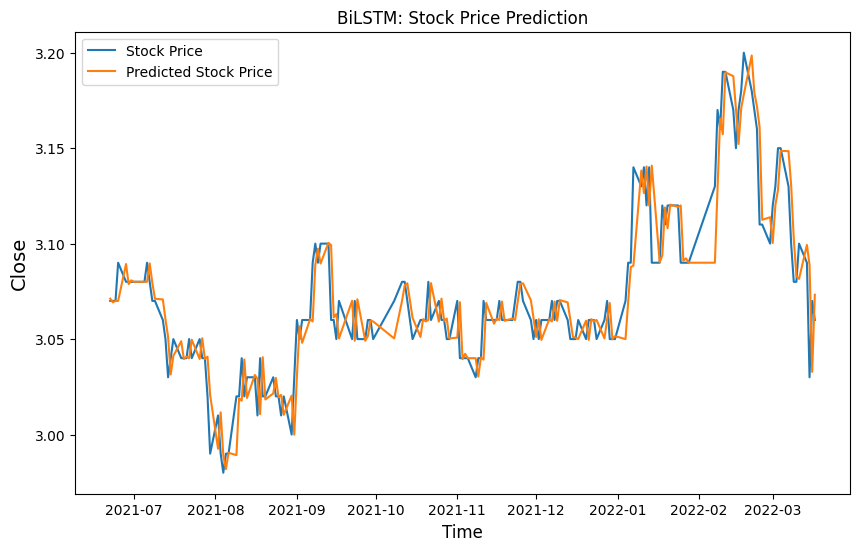

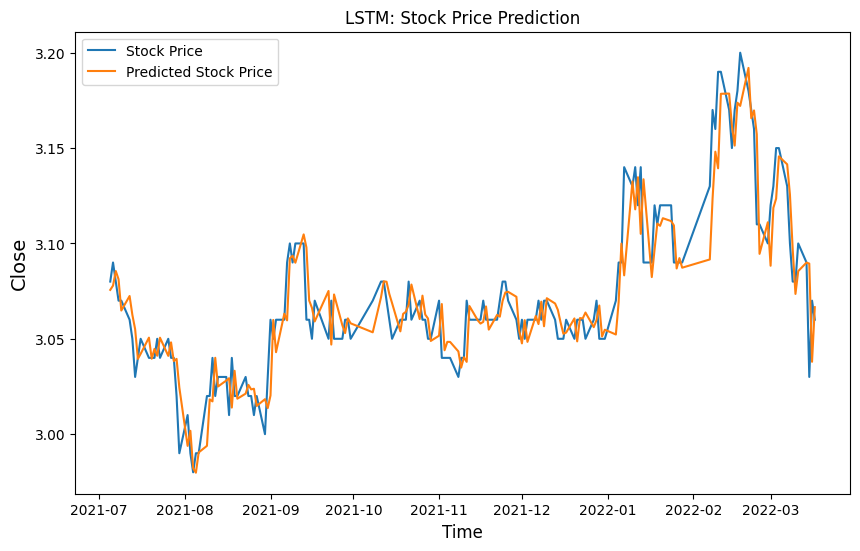

MSE: 0.00027
RMSE: 0.01650
MAE: 0.01197
R2: 0.84235


In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.optimizers import Adam
# from tensorflow.keras.optimizers import Adam
from numpy.random import seed


gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.set_visible_devices([gpus[0]], "GPU")

seed(1)
tf.random.set_seed(1)

n_timestamp = 10
n_epochs = 50

model_type = 3

yuan_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/601988.SH.csv')
yuan_data.index = pd.to_datetime(yuan_data['trade_date'], format='%Y%m%d')
yuan_data = yuan_data.loc[:, ['open', 'high', 'low', 'close', 'amount']]

data = pd.read_csv('/content/ARIMA_residuals1.csv')
data.index = pd.to_datetime(data['trade_date'])
data = data.drop('trade_date', axis=1)
# data = pd.merge(data, yuan_data, on='trade_date')

Lt = pd.read_csv('/content/ARIMA.csv')
idx = 3500
training_set = data.iloc[1:idx, :]
test_set = data.iloc[idx:, :]
yuan_training_set = yuan_data.iloc[1:idx, :]
yuan_test_set = yuan_data.iloc[idx:, :]

sc = MinMaxScaler(feature_range=(0, 1))
yuan_sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.fit_transform(test_set)
yuan_training_set_scaled = yuan_sc.fit_transform(yuan_training_set)
yuan_testing_set_scaled = yuan_sc.fit_transform(yuan_test_set)

X_train, y_train = data_split(training_set_scaled, n_timestamp)
yuan_X_train, yuan_y_train = data_split(yuan_training_set_scaled, n_timestamp)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
yuan_X_train = yuan_X_train.reshape(yuan_X_train.shape[0], yuan_X_train.shape[1], 5)

X_test, y_test = data_split(testing_set_scaled, n_timestamp)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
yuan_X_test, yuan_y_test = data_split(yuan_testing_set_scaled, n_timestamp)
yuna_X_test = yuan_X_test.reshape(yuan_X_test.shape[0], yuan_X_test.shape[1], 5)

model, yuan_model = lstm(model_type,X_train,yuan_X_train)
print(model.summary())
adam1 = Adam(learning_rate=0.01)
adam2 = Adam(learning_rate=0.01)

model.compile(optimizer=adam1,
              loss='mse')
yuan_model.compile(optimizer=adam2,
                   loss='mse')

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=n_epochs,
                    validation_data=(X_test, y_test),
                    validation_freq=1)
yuan_history = yuan_model.fit(yuan_X_train, yuan_y_train,
                              batch_size=32,
                              epochs=n_epochs,
                              validation_data=(yuan_X_test, yuan_y_test),
                              validation_freq=1)


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('residuals: Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(yuan_history.history['loss'], label='Training Loss')
plt.plot(yuan_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM: Training and Validation Loss')
plt.legend()
plt.show()

yuan_predicted_stock_price = yuan_model.predict(yuan_X_test)
yuan_predicted_stock_price = yuan_sc.inverse_transform(yuan_predicted_stock_price)
yuan_predicted_stock_price_list = np.array(yuan_predicted_stock_price[:, 3]).flatten().tolist()
yuan_predicted_stock_price1 = {
    'trade_date': yuan_data.index[idx+10:],
    'close': yuan_predicted_stock_price_list
}
yuan_predicted_stock_price1 = pd.DataFrame(yuan_predicted_stock_price1)
yuan_predicted_stock_price1 = yuan_predicted_stock_price1.set_index(['trade_date'], drop=True)
yuan_real_stock_price = yuan_sc.inverse_transform(yuan_y_test)
yuan_real_stock_price_list = np.array(yuan_real_stock_price[:, 3]).flatten().tolist()
yuan_real_stock_price1 = {
    'trade_date': yuan_data.index[idx+10:],
    'close': yuan_real_stock_price_list
}
yuan_real_stock_price1 = pd.DataFrame(yuan_real_stock_price1)
yuan_real_stock_price1 = yuan_real_stock_price1.set_index(['trade_date'], drop=True)

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price_list = np.array(predicted_stock_price[:, 0]).flatten().tolist()

predicted_stock_price1 = {
    'trade_date': data.index[idx+10:],
    'close': predicted_stock_price_list
}
predicted_stock_price1 = pd.DataFrame(predicted_stock_price1)

predicted_stock_price1 = predicted_stock_price1.set_index(['trade_date'], drop=True)

real_stock_price = sc.inverse_transform(y_test)
finalpredicted_stock_price = pd.concat([Lt, predicted_stock_price1]).groupby('trade_date')['close'].sum().reset_index()
finalpredicted_stock_price.index = pd.to_datetime(finalpredicted_stock_price['trade_date'])
finalpredicted_stock_price = finalpredicted_stock_price.drop(['trade_date'], axis=1)

plt.figure(figsize=(10, 6))
# print('yuan_real', yuan_real_stock_price1)
plt.plot(yuan_data.loc['2021-06-22':, 'close'], label='Stock Price')
plt.plot(finalpredicted_stock_price['close'], label='Predicted Stock Price')
plt.title('BiLSTM: Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(yuan_real_stock_price1['close'], label='Stock Price')
plt.plot(yuan_predicted_stock_price1['close'], label='Predicted Stock Price')
plt.title('LSTM: Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

yhat = yuan_data.loc['2021-06-22':, 'close']
evaluation_metric(finalpredicted_stock_price['close'],yhat)

## Generate a Hybrid model by combining above models for better result to predict stock price

(7, 2)
(3478, 20, 7) (3478, 1)


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26            │ (None, 20, 7)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_18 (Conv1D)        │ (None, 20, 64)         │            512 │ input_layer_26[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_38 (Dropout)      │ (None, 20, 64)         │              0 │ conv1d_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_26          │ (None, 20, 128)        │         66,048 │ dropout_38[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_39 (Dropout)      │ (None, 20, 128)        │              0 │ bidirectional_26[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute_15 (Permute)      │ (None, 128, 20)        │              0 │ dropout_39[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_24 (Dense)          │ (None, 128, 20)        │            420 │ permute_15[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute_16 (Permute)      │ (None, 20, 128)        │              0 │ dense_24[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_9 (Multiply)     │ (None, 20, 128)        │              0 │ dropout_39[0][0],      │
│                           │                        │                │ permute_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_9 (Flatten)       │ (None, 2560)           │              0 │ multiply_9[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_25 (Dense)          │ (None, 1)              │          2,561 │ flatten_9[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,541 (271.64 KB)

 Trainable params: 69,541 (271.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 0.0226 - val_loss: 3.0426e-04
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0012 - val_loss: 1.9565e-04
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0012 - val_loss: 3.2147e-04
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0010 - val_loss: 1.2318e-04
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 8.8699e-04 - val_loss: 3.0499e-04
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 9.0069e-04 - val_loss: 1.1390e-04
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 7.2574e-04 - val_loss: 1.2157e-04
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 6.2916e-04 - val_loss: 5.1335e-04
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 7.1825e-04 - val_loss: 7.6827e-05
Epoch 10/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 5.7853e-04 - val_loss: 1.1500e-04
Epoch 11/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 6.7555e-04 - val_loss: 6

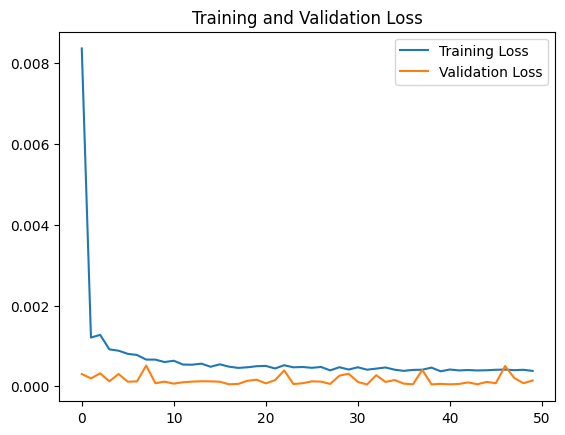

(7, 2)
(160, 20, 7) (160, 1)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
MSE: 0.12303
RMSE: 0.35076
MAE: 0.25430
R2: 0.69977


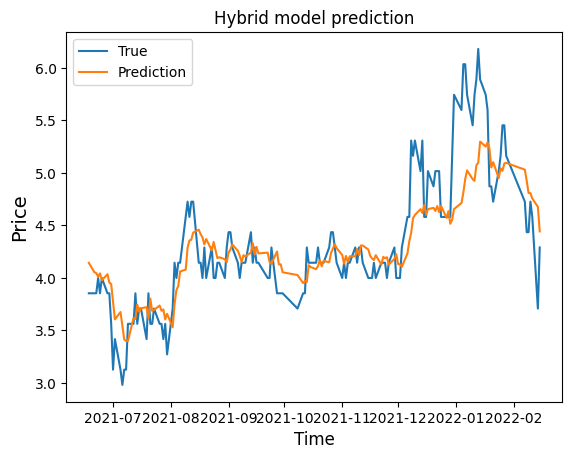

In [ ]:
from keras.layers import Input, Dense, LSTM, Conv1D, Dropout, Bidirectional, Multiply, Flatten, Permute, Lambda, RepeatVector
from keras.models import Model, Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import metrics

import keras.backend as K

data1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/601988.SH.csv")
data1.index = pd.to_datetime(data1['trade_date'], format='%Y%m%d')
data1 = data1.loc[:, ['open', 'high', 'low', 'close', 'vol', 'amount']]
data_yuan = data1
residuals = pd.read_csv('/content/ARIMA_residuals1.csv')
residuals.index = pd.to_datetime(residuals['trade_date'])
residuals.pop('trade_date')
data1 = pd.merge(data1, residuals, on='trade_date')
data = data1.iloc[1:3500, :]
data2 = data1.iloc[3500:, :]

TIME_STEPS = 20

data, normalize = NormalizeMult(data)
pollution_data = data[:, 3].reshape(len(data), 1)

train_X, _ = create_dataset(data, TIME_STEPS)
_, train_Y = create_dataset(pollution_data, TIME_STEPS)

print(train_X.shape, train_Y.shape)

# Attention model definition
def attention_3d_block(inputs, single_attention_vector=False):
    time_steps = inputs.shape[1]
    input_dim = inputs.shape[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1))(a)
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

def attention_model(INPUT_DIMS=7, TIME_STEPS=20, lstm_units=64):
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))
    x = Conv1D(filters=64, kernel_size=1, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    lstm_out = Dropout(0.3)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

m = attention_model(INPUT_DIMS=7)
m.summary()
adam = Adam(learning_rate=0.01)
m.compile(optimizer=adam, loss='mse')
history = m.fit([train_X], train_Y, epochs=50, batch_size=32, validation_split=0.1)
m.save("./stock_model.h5")
np.save("stock_normalize.npy", normalize)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

class Config:
    def __init__(self):
        self.dimname = 'close'

config = Config()
name = config.dimname
y_hat, y_test = PredictWithData(data2, data_yuan, name, 'stock_model.h5',7)
y_hat = np.array(y_hat, dtype='float64')
y_test = np.array(y_test, dtype='float64')
evaluation_metric(y_test, y_hat)
time = pd.Series(data1.index[3499:])
time = time[:len(y_test)]

plt.plot(time, y_test, label='True')
plt.plot(time, y_hat, label='Prediction')
plt.title('Hybrid model prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Price', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()
